# Image segmentation of Integrated Circuits

## Authors
Alex Marcelino Santee, n° USP: 10392226

Henrique Bonini de Britto Menezes, n° USP: 8956690

## Project goal

This project aims to automatically identify different layers and electrical components from an Integrated Circuit (IC) picture.

These layers are the regions filled with metal, polycristaline silicon, and P or N doped regions. They are used to build components like transistors, resistors and capacitors and then joined to make a complex circuit.

## Images used

The images this project is based on are from project5474.org, where many different high resolution images of simple ICs can be found.

The following images are examples of the High Speed CMOS family.

![54HC32](https://upload.wikimedia.org/wikipedia/commons/thumb/9/92/54HC32_RCA_8825_die_120nmpp.jpg/467px-54HC32_RCA_8825_die_120nmpp.jpg)
![54HC00](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/54HC00_NS_8632_die_120nmpp.jpg/578px-54HC00_NS_8632_die_120nmpp.jpg)
![74HC00](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4b/74HCT00_RCA_419_die_120nmpp.jpg/482px-74HCT00_RCA_419_die_120nmpp.jpg)
![74HC02](https://upload.wikimedia.org/wikipedia/commons/thumb/2/25/74HC02_Motorola_8302.jpg/629px-74HC02_Motorola_8302.jpg)

In [4]:
# init libraries
import imageio.v2 as imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from skimage import morphology
from skimage.segmentation import flood_fill
from sklearn.cluster import KMeans
from sklearn.utils import shuffle

# Original image used throuout the notebook
filename = "54HC32_RCA_8825_die_120nmpp.jpg"

## Metal layer extraction

The first layer we tried to extract was the metal layer, since it is clearly visible as a bright white through all the image.
To extract it we initially applied a median filter to the image, in order to reduce visible dust, and then used a thresholding method on the image in HSV colour space, where white has a low saturation and high value.

/home/hbritto/.pyenv/versions/scc5830/lib64/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (105218190 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


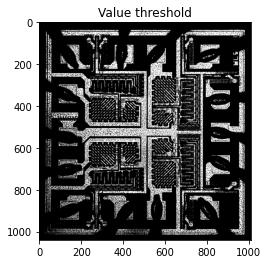

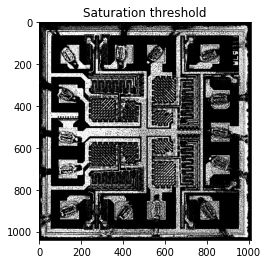

In [5]:
# init constants for thresholding
DOWNSAMPLING = 10
MEDIAN_RADIUS = 12 // DOWNSAMPLING
VALUE_THRESHOLD = 220
SAT_THRESHOLD = 0.05
CLOSING_SIZE = 1

# We downsample the image for better execution times
img = imageio.imread(filename)
img = img[::DOWNSAMPLING, ::DOWNSAMPLING, :]

# The convert the image to HSV colourspace and separate the saturation and value channels
img_hsv = mpl.colors.rgb_to_hsv(img)
img_sat = img_hsv[:, :, 1]
img_val = img_hsv[:, :, 2]

# Median filter gets rid of dust particles, but loses resolution
median_img_sat = ndimage.median_filter(img_sat, size=MEDIAN_RADIUS)
median_img_val = ndimage.median_filter(img_val, size=MEDIAN_RADIUS)

# uses threshold to extract metal layer
size = img_val.shape[:2]
v_thres = (img_val > VALUE_THRESHOLD) * np.ones(size, dtype="bool")
s_thres = (img_sat < SAT_THRESHOLD) * np.ones(size, dtype="bool")

plt.imshow(v_thres, cmap="gray")
plt.title("Value threshold")
plt.show()
plt.imshow(s_thres, cmap="gray")
plt.title("Saturation threshold")
plt.show()


However this method had some visible defects because of the black circles which were present in the image (they are present because of dust particles on the lenses during the lithography process). To avoid them we tried a median filter to get a image without the black circles and then used an union operation with the original extraction to not lose details.

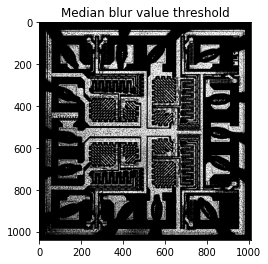

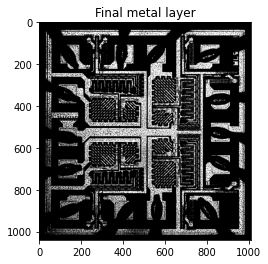

In [6]:
v_med_thres = (median_img_val > VALUE_THRESHOLD) * np.ones(size, dtype="bool")
# s_med_thres = (median_img_sat<  SAT_THRESHOLD)*np.ones(size, dtype="bool")

metal = (v_thres & s_thres) | v_med_thres  # & s_med_thres)

plt.imshow(v_med_thres, cmap="gray")
plt.title("Median blur value threshold")
plt.show()
plt.imshow(metal, cmap="gray")
plt.title("Final metal layer")
plt.show()


But still the results were not so good, so we applied a morphological closing to the image, as an attempt to eliminate small elements and holes.

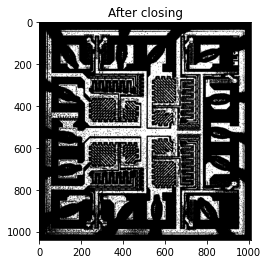

In [7]:
img_closing = morphology.binary_closing(metal, morphology.disk(CLOSING_SIZE))
plt.imshow(img_closing, cmap="gray")
plt.title("After closing")
plt.show()

To evaluate these results more precisely, we manually segmented the original image, creating a ground truth for the algorithm, and compared the results with it.

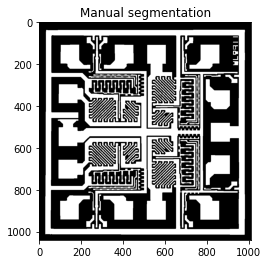

In [8]:
ref_filename = "manual_segmentation/54HC32_metal.gif"
ref_img = imageio.imread(ref_filename)
ref_img = ref_img[::DOWNSAMPLING,::DOWNSAMPLING,:]
ref_metal = ref_img[:, :, 0] > 0

plt.imshow(ref_metal, cmap="gray")
plt.title("Manual segmentation")
plt.show()

True positive:   23.84 %
True negative:   55.46 %
Correct ratio:   79.30 %
False positive:  0.28 %
False negative:  20.42 %
Incorrect ratio: 20.70 %


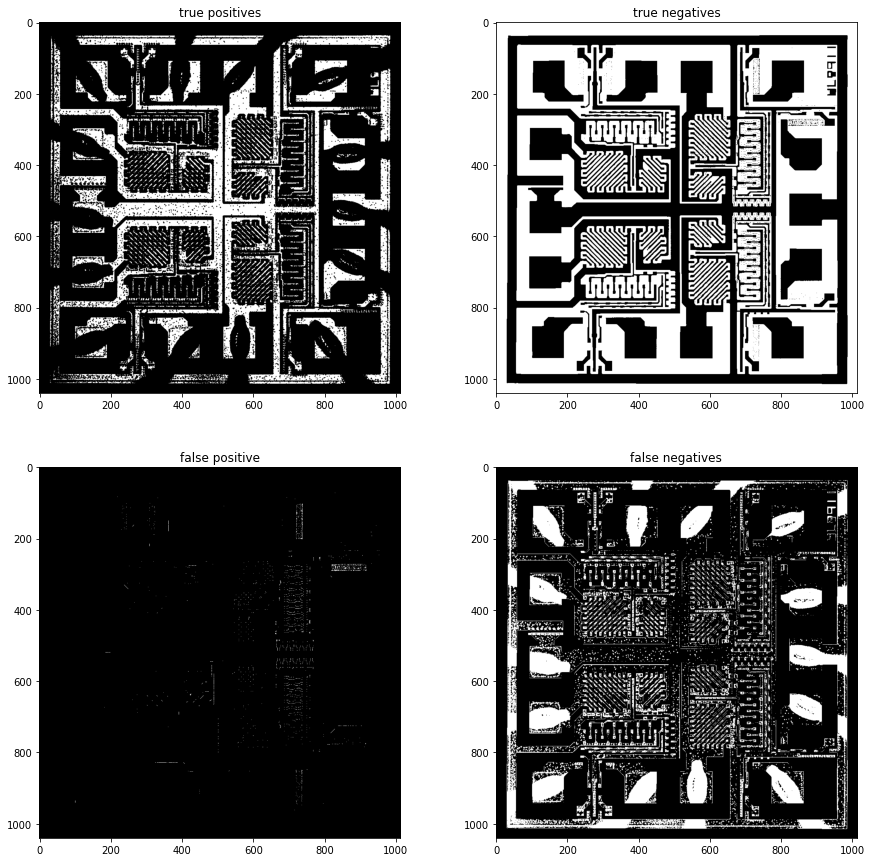

In [9]:
X, Y, _ = img.shape
tp = img_closing & ref_metal
tn = np.logical_not(img_closing) & np.logical_not(ref_metal)
fp = img_closing & np.logical_not(ref_metal)
fn = np.logical_not(img_closing) & ref_metal

r_tp = np.sum(tp) / (X * Y)
r_tn = np.sum(tn) / (X * Y)
r_fp = np.sum(fp) / (X * Y)
r_fn = np.sum(fn) / (X * Y)

print(f"True positive:   {100*(r_tp):.2f} %")
print(f"True negative:   {100*(r_tn):.2f} %")
print(f"Correct ratio:   {100*(r_tp+r_tn):.2f} %")
print(f"False positive:  {100*(r_fp):.2f} %")
print(f"False negative:  {100*(r_fn):.2f} %")
print(f"Incorrect ratio: {100*(r_fp+r_fn):.2f} %")

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
plt.set_cmap("gray")
axs[0][0].set_title("true positives")
axs[0][0].imshow(tp)
axs[0][1].set_title("true negatives")
axs[0][1].imshow(tn)
axs[1][0].set_title("false positive")
axs[1][0].imshow(fp)
axs[1][1].set_title("false negatives")
axs[1][1].imshow(fn)
plt.show()

From these results it can be seen that the method correctly extracted the bigger chunks of metal, but failed for the metal under the black wire bondings and some smaller layers. It has a very low rate of false positives, therefore does not create electrical connections that should not exist.

## K-means metal extraction

After the thresholding method, since it didn't have a very good correct ratio, we tried a different approach, using a K-Means clusterisation of the image.

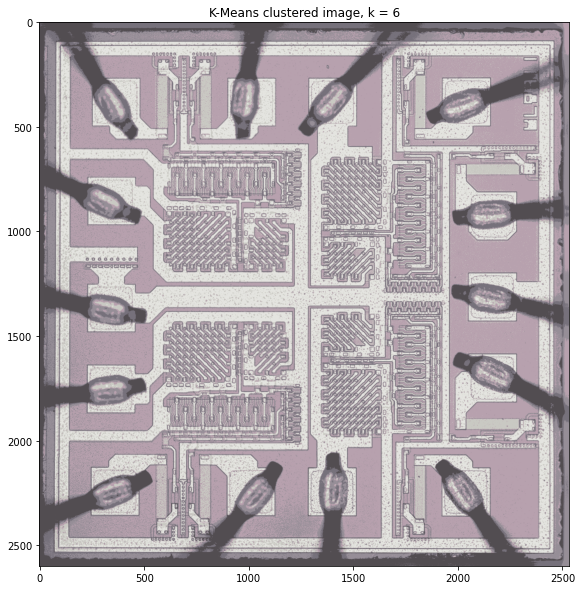

In [10]:
N_CLUSTERS = 6
SUBSET_SIZE = 1000
DOWNSAMPLING = 4
CLOSING_SIZE = 20 // DOWNSAMPLING

# reading input image
img = imageio.imread(filename)
img = img[::DOWNSAMPLING, ::DOWNSAMPLING, :]
X, Y, _ = img.shape

# k_mean clustering
img_2d = np.reshape(img, (X * Y, 3))
subset = shuffle(img_2d, n_samples=SUBSET_SIZE)
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(subset)
labels = kmeans.predict(img_2d)
clustered_img = kmeans.cluster_centers_[labels].reshape(X, Y, -1) / 255.0
plt.figure(figsize=(10, 10))
plt.imshow(clustered_img)
plt.title(f"K-Means clustered image, k = {N_CLUSTERS}")
plt.show()


The resulting image still had holes, so we applied a morphological closing to it and compared results with the ground truth, with much better numbers this time.

/home/hbritto/.pyenv/versions/scc5830/lib64/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (105218190 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


True positive:   13.95 %
True negative:   1.33 %
Correct ratio:   15.28 %
False positive:  54.25 %
False negative:  30.47 %
Incorrect ratio: 84.72 %



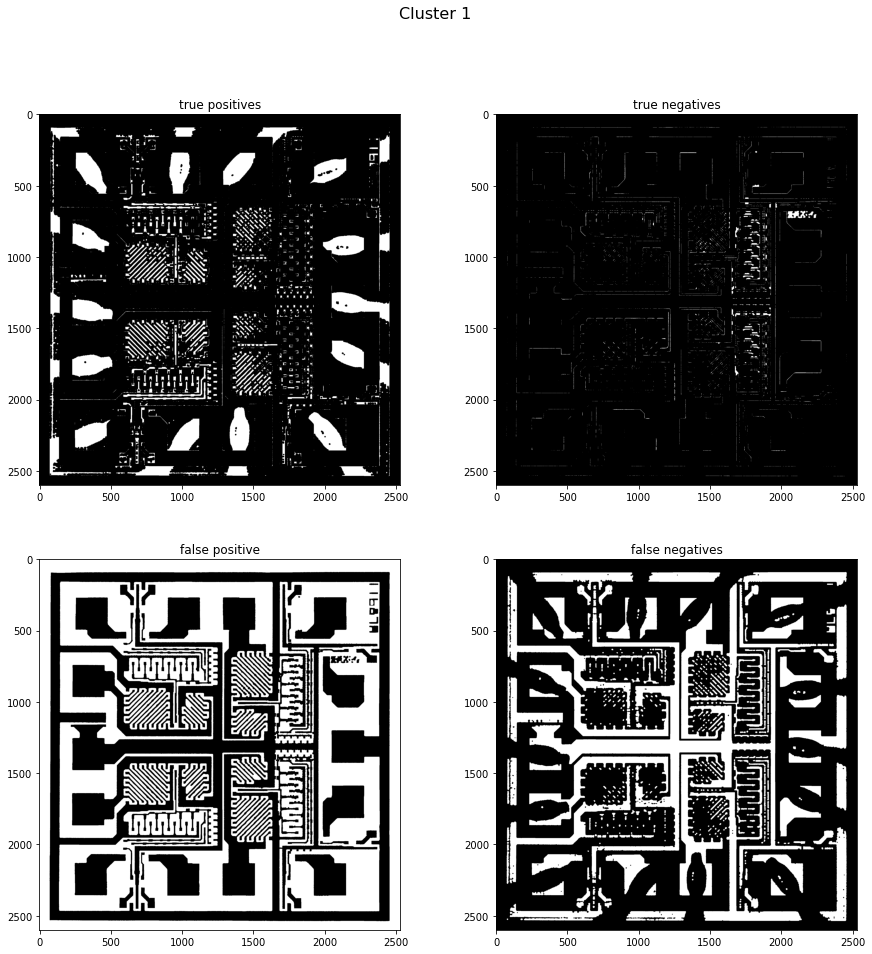

True positive:   32.02 %
True negative:   54.32 %
Correct ratio:   86.33 %
False positive:  1.26 %
False negative:  12.41 %
Incorrect ratio: 13.67 %



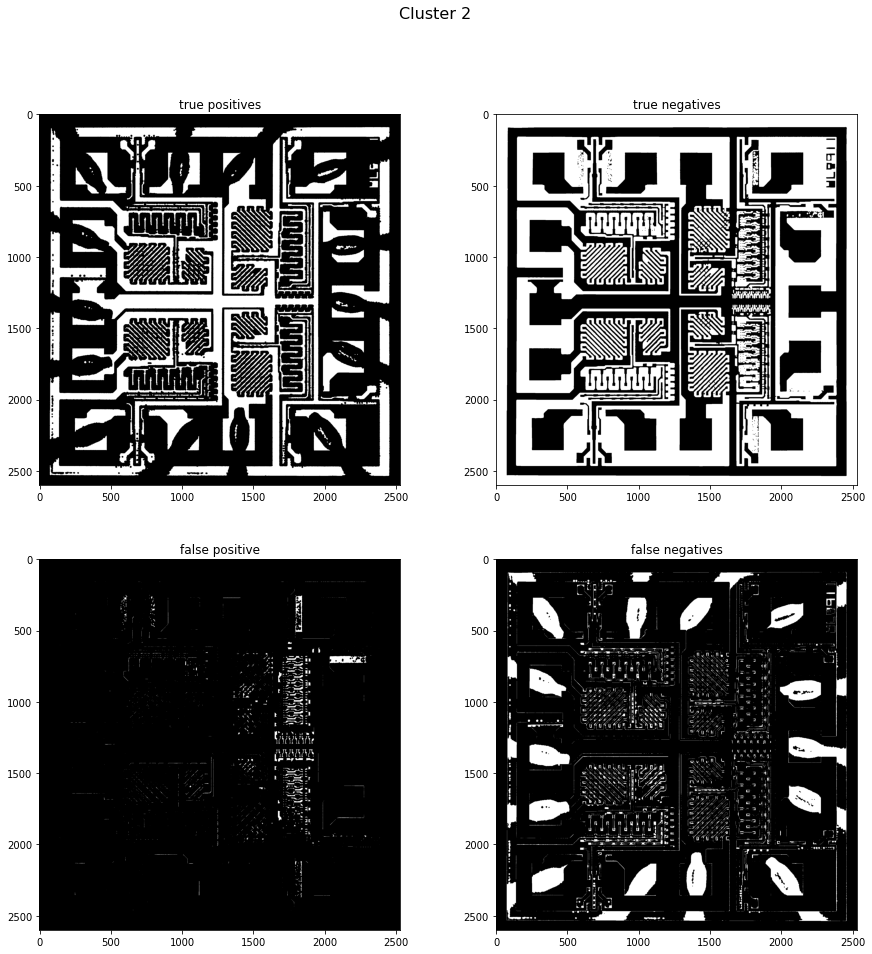

True positive:   12.06 %
True negative:   53.56 %
Correct ratio:   65.61 %
False positive:  2.02 %
False negative:  32.37 %
Incorrect ratio: 34.39 %



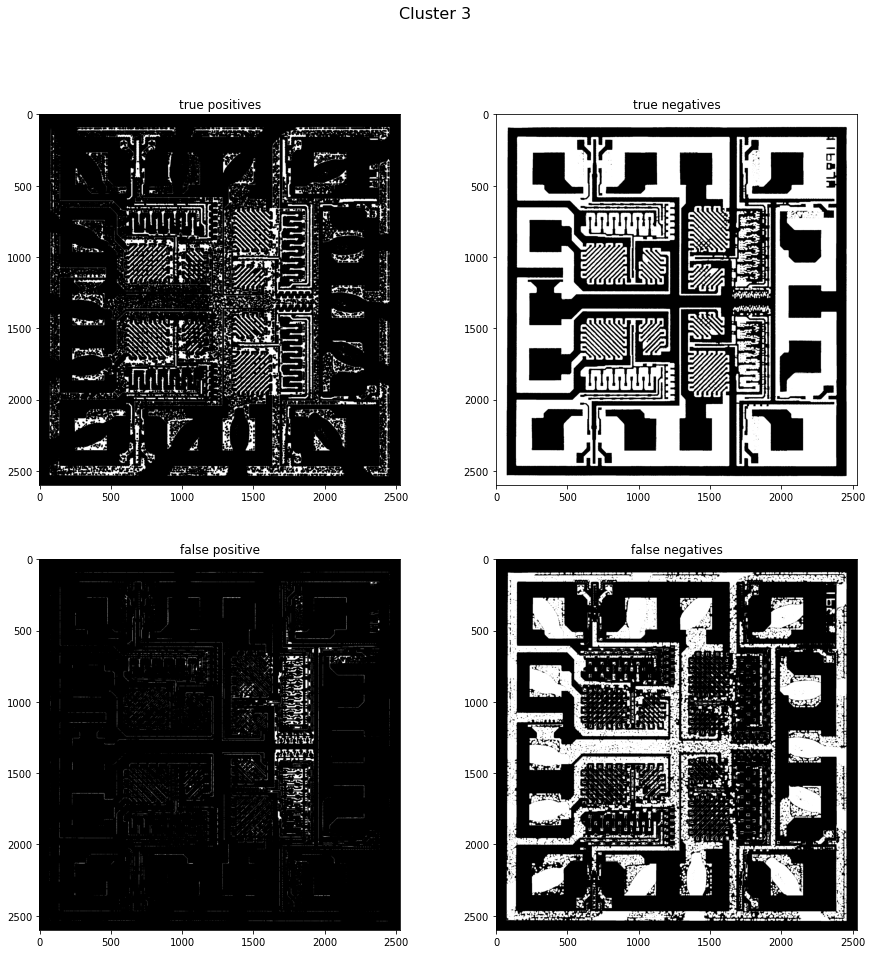

In [21]:
ref_filename = "manual_segmentation/54HC32_metal.gif"
ref_img = imageio.imread(ref_filename)
ref_img = ref_img[::DOWNSAMPLING,::DOWNSAMPLING,:]
ref_metal = ref_img[:, :, 0] > 0

labels2d = labels.reshape(X,Y)
for cluster in range(N_CLUSTERS):
    metal = (labels2d == cluster)
    metal = morphology.binary_closing(metal, morphology.disk(CLOSING_SIZE))
    imageio.imwrite(f"metal_jupyter/{cluster}.gif", 255*metal.astype(np.uint8))

    # Verifies results with reference for true and false positives and negatives
    tp = metal & ref_metal
    tn = np.logical_not(metal) & np.logical_not(ref_metal)
    fp = metal & np.logical_not(ref_metal)
    fn = np.logical_not(metal) & ref_metal

    r_tp = np.sum(tp) / (X * Y)
    r_tn = np.sum(tn) / (X * Y)
    r_fp = np.sum(fp) / (X * Y)
    r_fn = np.sum(fn) / (X * Y)

    print(f"True positive:   {100*(r_tp):.2f} %")
    print(f"True negative:   {100*(r_tn):.2f} %")
    print(f"Correct ratio:   {100*(r_tp+r_tn):.2f} %")
    print(f"False positive:  {100*(r_fp):.2f} %")
    print(f"False negative:  {100*(r_fn):.2f} %")
    print(f"Incorrect ratio: {100*(r_fp+r_fn):.2f} %")
    print()

    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    plt.set_cmap("gray")
    fig.suptitle(f"Cluster {cluster + 1}", fontsize=16)
    axs[0][0].set_title("true positives")
    axs[0][0].imshow(tp)
    axs[0][1].set_title("true negatives")
    axs[0][1].imshow(tn)
    axs[1][0].set_title("false positive")
    axs[1][0].imshow(fp)
    axs[1][1].set_title("false negatives")
    axs[1][1].imshow(fn)
    plt.show()

We can see that the cluster n° 2 had the best results for the metal layer.

For the other images there was not ground truth created, but upon manual inspection, the segmentation seems good.

/home/hbritto/.pyenv/versions/scc5830/lib64/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (155309040 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


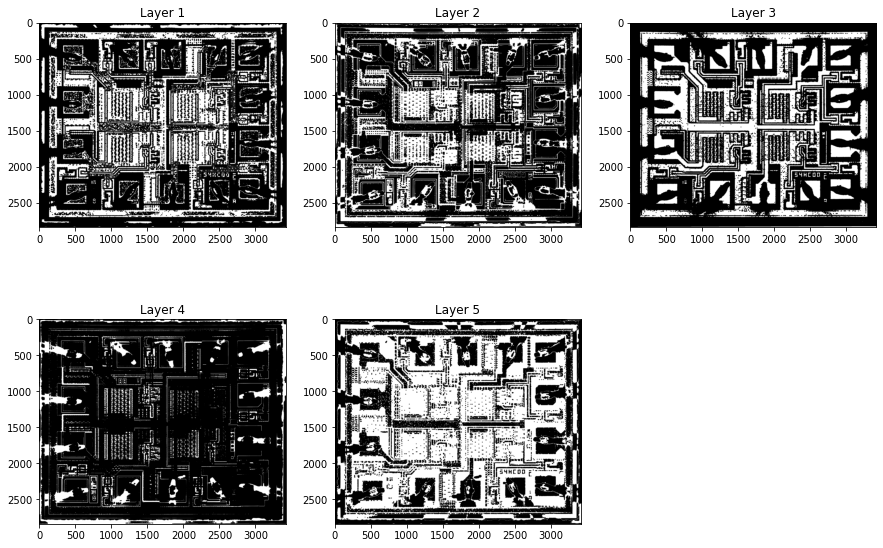

/home/hbritto/.pyenv/versions/scc5830/lib64/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (170406016 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


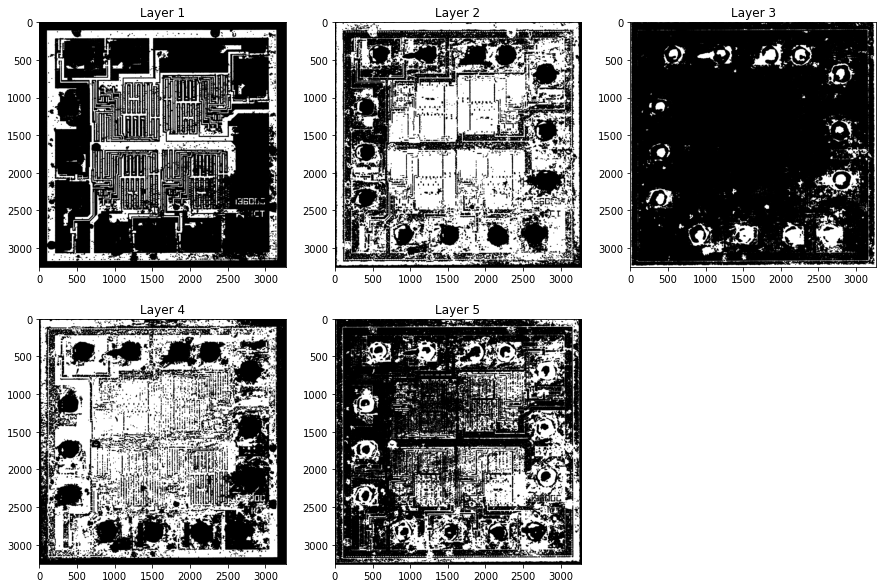

/home/hbritto/.pyenv/versions/scc5830/lib64/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (158621877 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


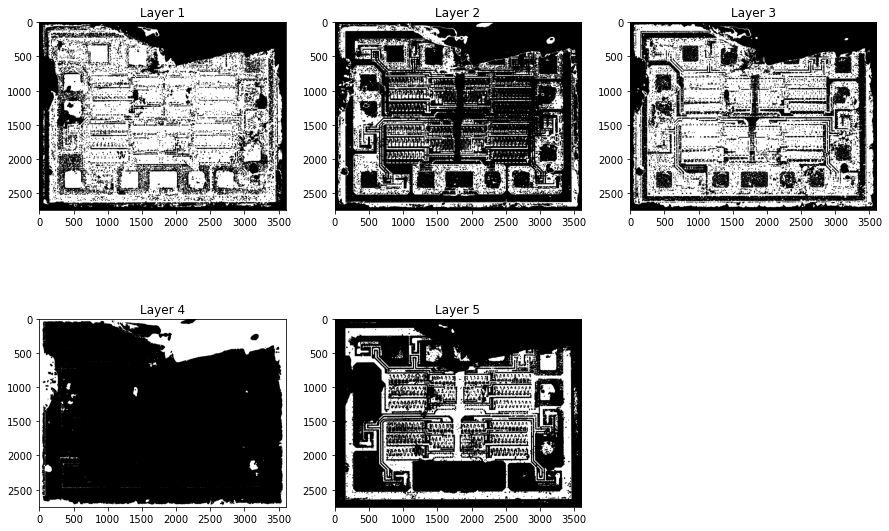

In [12]:
N_CLUSTERS = 5
SUBSET_SIZE = 1000
DOWNSAMPLING = 4
CLOSING_SIZE = 20 // DOWNSAMPLING

imagenames = ('54HC00_NS_8632_die_120nmpp.jpg', '74HCT00_RCA_419_die_120nmpp.jpg', '74HC02_Motorola_8302.jpg')

for imgname in imagenames:
    img = imageio.imread(imgname)
    img = img[::DOWNSAMPLING, ::DOWNSAMPLING, :]
    X, Y, _ = img.shape

    img_2d = np.reshape(img, (X * Y, 3))
    subset = shuffle(img_2d, n_samples=SUBSET_SIZE)
    kmeans = KMeans(n_clusters=N_CLUSTERS).fit(subset)
    labels = kmeans.predict(img_2d)
    clustered_img = kmeans.cluster_centers_[labels].reshape(X, Y, -1) / 255.0

    labels2d = labels.reshape(X,Y)
    segmented = []
    for cluster in range(N_CLUSTERS):
        metal = (labels2d == cluster)
        metal = morphology.binary_closing(metal, morphology.disk(CLOSING_SIZE))
        segmented.append(metal)

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    plt.set_cmap("gray")
    i = j = 0
    for ind, seg in enumerate(segmented):
        axs[i][j].set_title(f"Layer {ind + 1}")
        axs[i][j].imshow(seg)
        j += 1
        j %= 3
        i = i + 1 if j == 0 else i
    fig.delaxes(axs[1, 2])
    plt.show()

## Via extraction

After those interesting results with k-means clusterisation, we begun to extract the IC's vias, using the metal layers extracted as masks for the original image.
The masked image is then clusterised with the same k-means algorithm, identifying the dark regions at the metal layer.

### Flood Fill

The algorithm used for the vias identification then was flood-filling the outside of the image, because then only the encircled regions, characteristic of vias, will not get flooded. This set of pixels is then complemented so that vias are 1 and dilated to compensate for border loss during flood fill.

/home/hbritto/.pyenv/versions/scc5830/lib64/python3.10/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (105218190 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


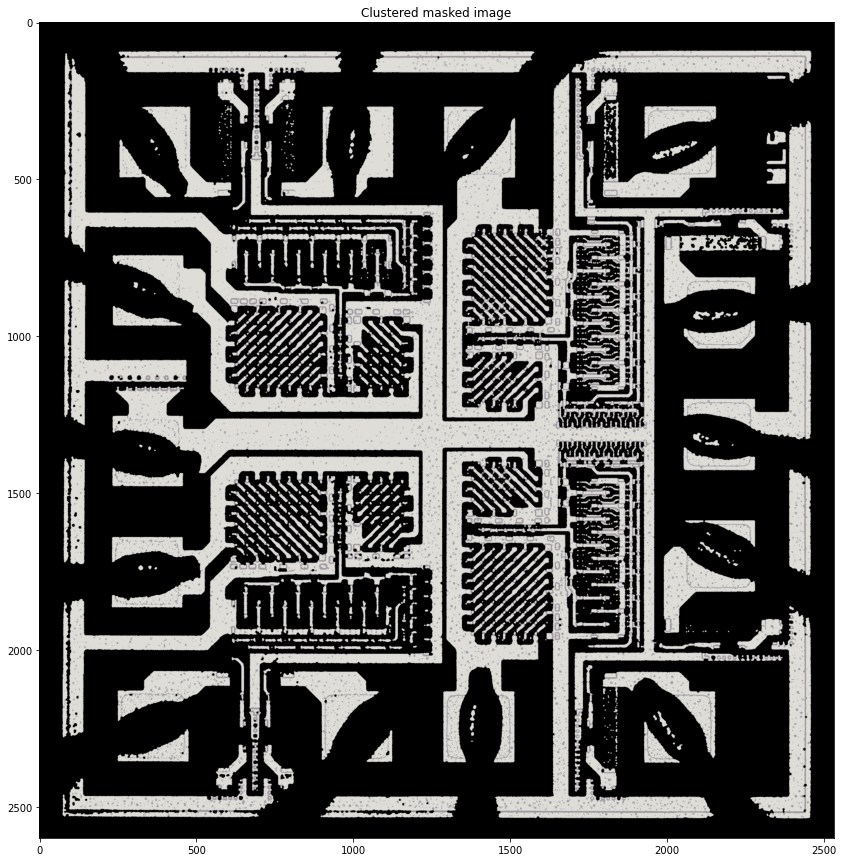

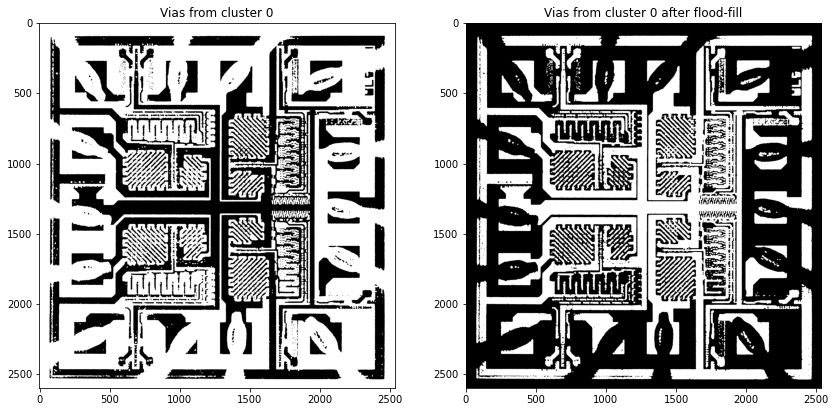

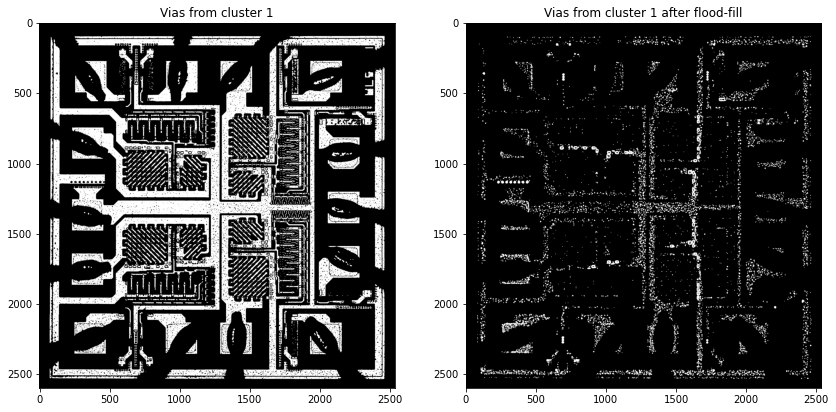

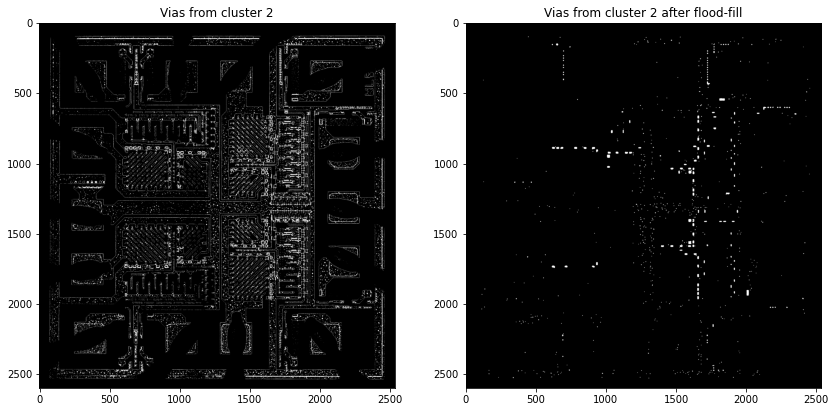

In [19]:
N_CLUSTERS = 3
SUBSET_SIZE = 1000
DOWNSAMPLING = 4
METAL_DILATION_SIZE = 10 // DOWNSAMPLING
VIA_DILATION_SIZE = 10 // DOWNSAMPLING

# Layers from metal segmentation to use
metal_indexes = (0,)
img = imageio.imread(filename)
img = img[::DOWNSAMPLING, ::DOWNSAMPLING, :]
X, Y, _ = img.shape
# Reading metal masks
mask = np.zeros((X, Y), dtype=np.bool8)
for i in metal_indexes:
    mask = np.logical_or(mask, imageio.imread(f"metal_jupyter/{i}.gif"))

# Use dilation as margin of error for metal
mask = morphology.binary_dilation(mask, morphology.disk(METAL_DILATION_SIZE))
# Apply metal as mask (every via is below metal)
mask = np.reshape(np.repeat(mask, 3), (X, Y, 3))
img = img * (mask > 0)

# k_means clustering masked image
img_2d = np.reshape(img, (X * Y, 3))
subset = shuffle(img_2d, n_samples=SUBSET_SIZE)
kmeans = KMeans(n_clusters=N_CLUSTERS).fit(subset)
labels = kmeans.predict(img_2d)
clustered_img = kmeans.cluster_centers_[labels].reshape(X, Y, -1) / 255.0
plt.figure(figsize=(15, 15))
plt.imshow(clustered_img)
plt.title("Clustered masked image")
plt.show()

labels2d = labels.reshape(X, Y)
for cluster in range(N_CLUSTERS):
    via = labels2d == cluster
    plt.figure(figsize=(14, 15))
    plt.subplot(1, 2, 1)
    plt.imshow(via, cmap="gray")
    plt.title(f"Vias from cluster {cluster}")
    # flood fill to get just covered regions
    via = flood_fill(via, (0, 0), True)
    via = np.logical_not(via)
    # dilation to recover lost area of contour from flood_fill
    via = morphology.binary_dilation(via, morphology.disk(VIA_DILATION_SIZE))
    imageio.imwrite(f"via_jupyter/{cluster}.gif", 255 * via.astype(np.uint8))
    plt.subplot(1, 2, 2)
    plt.imshow(via, cmap="gray")
    plt.title(f"Vias from cluster {cluster} after flood-fill")
    plt.show()



As can be seen in the previous images, the vias from cluster 2 after flood-fill were the best results of the method, and, despite not being perfect, most visible vias have been extracted.

## Future works

For next iterations and improvements of the project, it is important to automatically retrieve the best cluster from the K-Means results.
It is also important to further develop the segmentation steps, for retrieval of the remaining layers from ICs, like polycrystalline silicon and P and N doped regions, used to create transistor arrays, resistors, capacitors and other components alike, completing the integrated circuit.